In [410]:
# Deskriptive Statistik

# Testdaten löschen

import operator
from dateutil import parser
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import re
import json
import pandas as pd
from matplotlib_venn import venn2, venn3, venn3_circles

In [350]:
# Synonyme für PFP als Liste
pfp_gen = ['Pflegefachperson', 'Pflegefachfrau', 'Pflegefachmann', 'Pflegefachkraft']
pfp_kh =  ['Krankenschwester', 'Krankenpfleger', 'Krankenpflegefachperson']
pfp_ap = ['Altenpfleger', 'Altenpflegefachkraft', 'Altenpflegefachperson']
pfp_ki = ['Kinderkrankenschwester', 'Kinderkrankenpfleger', 'Kinderkrankenpflegefachperson'] 
# Die Bezeichnungen in pfp_ki entsprechen den Bezeichnungen in pfp_kh mit dem Zusatz "Kinder".
# Falls in pfp_ki eine Bezeichnung steht, die dieser Regel widerspricht, so wird diese nicht gezählt!!
# Außerdem muss pfp_ki[n] auch pfp_kh[n] entsprechen (jeweils mit/ohne Kinder-), sonst funktioniert der Zähler nicht (Z. 142f.)!
# Dieser Regel darf also nicht widersprochen werden!
# Weibliche Formen, die nur durch -in entstehen, werden nicht beachtet bzw. zählen zu den männlichen dazu

In [351]:
#Testdaten
"""output = {
    "date": {
        "0":"2020-08-01",
        "1":"2024-06-07",
        "2":"2025-01-03",
        "3":"2024-01-01",
        "4":"2025-07-04",
        "5":"2025-01-01",
        "6":"2023-12-31",
        "7":"2023-02-01",
        "8":"2024-02-02",
        "9":"2024-03-02"},
    "full_text": {
        "0":"abcAltenpflegerjhk",
        "1":"123Altenpflegefachkraft123",
        "2":"abcAltenpflegerinabc",
        "3":"abcdPflegefachperson123",
        "4":"123Krankenpflegerinabc",
        "5":"abcd Pflegefachmann 123",
        "6":"Krankenschwester12acde",
        "7":"abcdPflegefachfrau74",
        "8":"Krankenpflegerabcd",
        "9":"aKinderkrankenpflegerb"}
    }"""
# Echte Daten
with open('Pflege_2016.json', 'r') as file:
    output = json.load(file)

In [430]:
sorted_indices = sorted(output["date"], key=lambda i: output["date"][i])
read = {
    "date": {str(idx): output["date"][i] for idx, i in enumerate(sorted_indices)},
    "full_text": {str(idx): output["full_text"][i] for idx, i in enumerate(sorted_indices)}
}
df = pd.DataFrame(read)
df_full = pd.DataFrame({
    "date": [output["date"][i] for i in sorted_indices],
    "full_text": [output["full_text"][i] for i in sorted_indices],
    "via_intermediary": [output["via_intermediary"][i] for i in sorted_indices],
    "contract_type": [output["contract_type"][i] for i in sorted_indices]
})

In [356]:
print('Insgesamt '+str(len(read["date"]))+' Stellenanzeigen gefunden')
first_key = list(read["date"].keys())[0]  # Ersten Schlüssel abrufen
first_value = read["date"][first_key]  # Entsprechenden Wert abrufen
print('Älteste Anzeige ist von '+first_value)
last_key = list(read["date"].keys())[-1]  # Letzten Schlüssel abrufen
last_value = read["date"][last_key]  # Entsprechenden Wert abrufen
print('Neuste Anzeige ist von '+last_value)

Insgesamt 118848 Stellenanzeigen gefunden
Älteste Anzeige ist von 2016-01-01
Neuste Anzeige ist von 2016-12-31


In [260]:
# Verteilung plotten (x=Monat/Jahr, y=Anzahl Stellenanzeigen); zuerst: Monate, Jahre und Anzahlen pro Monat und Jahr extrahieren
timestamps = [datetime.strptime(date, "%Y-%m-%d") for date in read["date"].values()]
months = sorted({(ts.year, ts.month) for ts in timestamps})
month_labels = [datetime(year, month, 1).strftime("%b %Y") for year, month in months]
month_counts = {month: 0 for month in months}
years = sorted({ts.year for ts in timestamps})
year_counts = {year: 0 for year in years}
for ts in timestamps:
    month_counts[(ts.year, ts.month)] += 1
    year_counts[ts.year] += 1

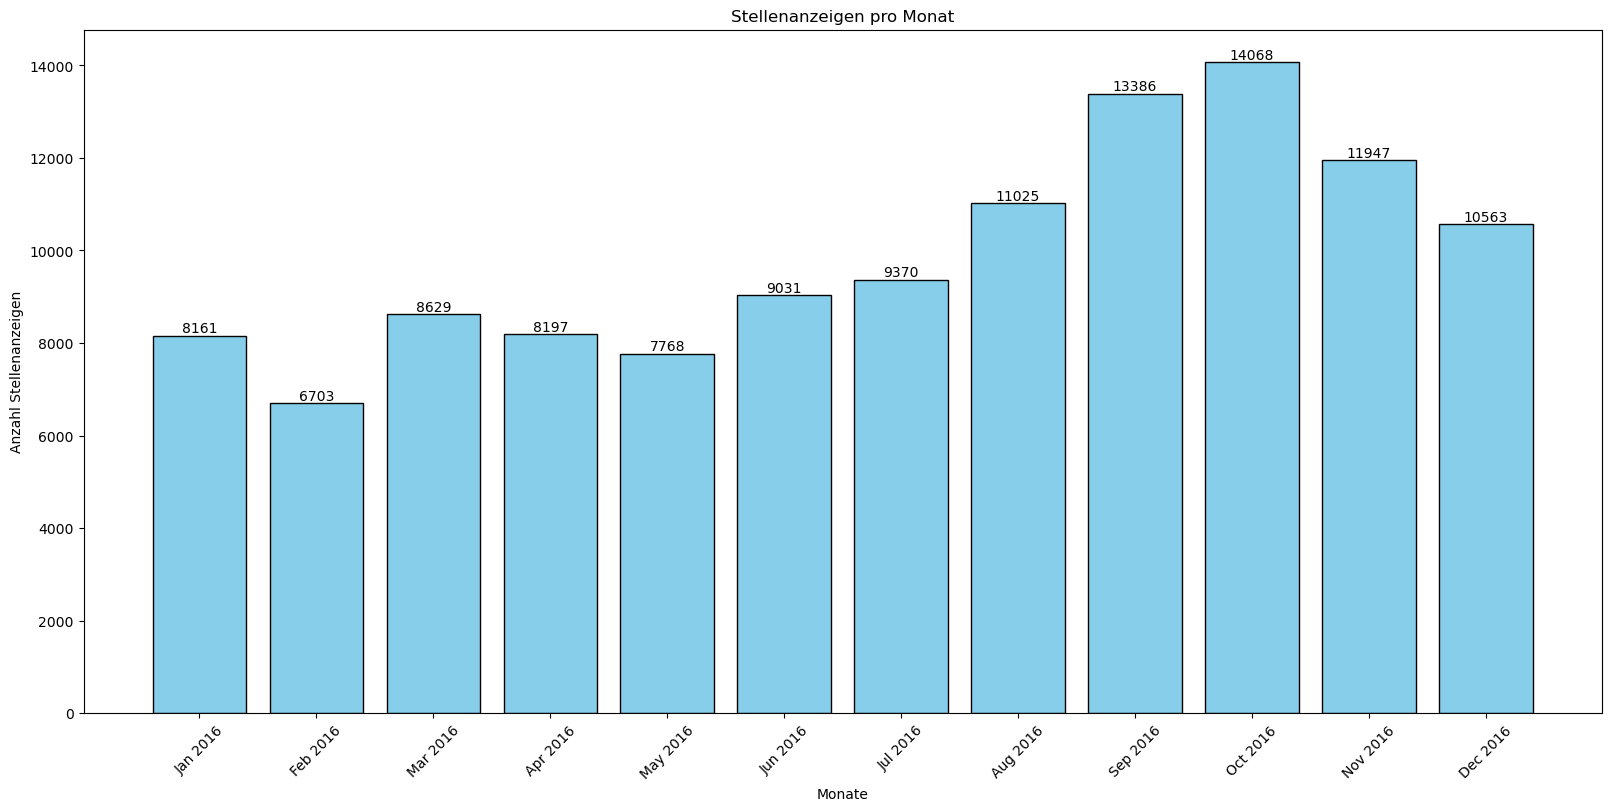

In [264]:
# Stellenanzeigen pro Monat
xmonths = np.arange(len(month_labels))
ymonths = [month_counts[month] for month in months]
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 8), constrained_layout=True, gridspec_kw={'height_ratios': [1]}) # viermal die eins am ende bei 4x4
ax = axes
barone = ax.bar(xmonths, ymonths, color='skyblue', edgecolor='black')
for rect in barone:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.5, str(height), ha='center', va='bottom')
ax.set_xticks(xmonths)
ax.set_xticklabels(month_labels, rotation=45)
ax.set_xlabel('Monate')
ax.set_ylabel('Anzahl Stellenanzeigen')
ax.set_title('Stellenanzeigen pro Monat')
plt.show()

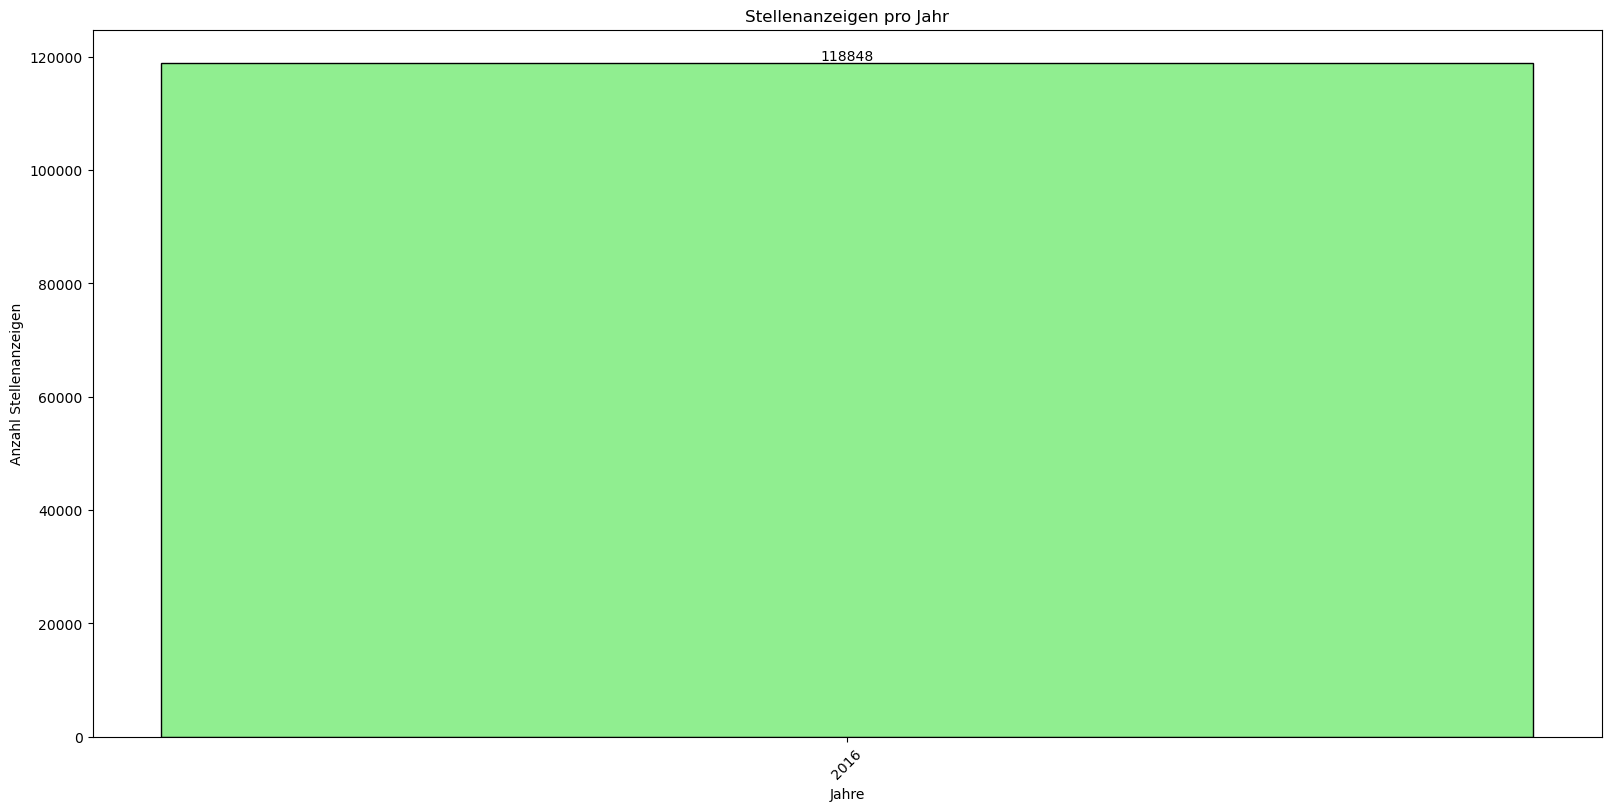

In [265]:
# Stellenanzeigen pro Jahr
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 8), constrained_layout=True, gridspec_kw={'height_ratios': [1]}) # viermal die eins am ende bei 4x4
xyears = np.arange(len(years))
yyears = [year_counts[year] for year in years]
ax = axes
bartwo = ax.bar(xyears, yyears, color='lightgreen', edgecolor='black')
for rect in bartwo:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.5, str(height), ha='center', va='bottom')
ax.set_xticks(xyears)
ax.set_xticklabels(years, rotation=45)
ax.set_xlabel('Jahre')
ax.set_ylabel('Anzahl Stellenanzeigen')
ax.set_title('Stellenanzeigen pro Jahr')
plt.show()

In [268]:
# Verteilung nach einzelnen Stellenbezeichnungen (sind als Liste in Variable pfp)
counter_gen = []
counter_kh = []
counter_ap = []
counter_ki = []
counter_gen_gesamt = 0
counter_kh_gesamt = 0
counter_ap_gesamt = 0
counter_ki_gesamt = 0
stellen_full_gen = []
stellen_full_kh = []
stellen_full_ap = []
stellen_full_ki = []
for c_pfp in pfp_gen:
    counter_gen.append([c_pfp, 0])
for c1_pfp in pfp_kh:
    counter_kh.append([c1_pfp, 0])
for c2_pfp in pfp_ap:
    counter_ap.append([c2_pfp, 0])
for c3_pfp in pfp_ki:
    counter_ki.append([c3_pfp, 0])
read_counter = len(read["date"])
for p in range(len(pfp_kh)):  # Iteriere über alle Suchbegriffe
    for n_key, n_text in read["full_text"].items():  # Richtig: Key und Wert extrahieren
        if re.search(rf".*{pfp_kh[p]}.*", n_text, flags=re.M | re.I):  # Korrekte Nutzung
            if re.search(rf".*{pfp_ki[p]}.*", n_text, flags=re.M | re.I):  # Zweite Prüfung
                counter_ki[p][1] += 1
                counter_ki_gesamt += 1
                stellen_full_ki.append([read["date"][n_key], n_text])  # Richtiger Zugriff
                read["date"][n_key] = "a"  # Korrekte Zuordnung
                read["full_text"][n_key] = "a"
            else:
                counter_kh[p][1] += 1
                counter_kh_gesamt += 1
                stellen_full_kh.append([read["date"][n_key], n_text])  # Richtiger Zugriff
                read["date"][n_key] = "a"  # Korrekte Zuordnung
                read["full_text"][n_key] = "a"
print("erste for-schleife fertig")
for q in range(len(pfp_ap)):
    for n_key, n_text in read["full_text"].items():  # Richtig: Key und Wert extrahieren
        if re.search(rf".*{pfp_ap[q]}.*", n_text, flags=re.M | re.I):  # Korrekte Nutzung
            counter_ap[q][1] += 1
            counter_ap_gesamt += 1
            stellen_full_ap.append([read["date"][n_key], n_text])  # Richtiger Zugriff
            read["date"][n_key] = "a"  # Korrekte Zuordnung
            read["full_text"][n_key] = "a"
print("zweite for-schleife fertig")
for l in range(len(pfp_gen)):
    for n_key, n_text in read["full_text"].items():  # Richtig: Key und Wert extrahieren
        if re.search(rf".*{pfp_gen[l]}.*", n_text, flags=re.M | re.I):  # Korrekte Nutzung
            counter_gen[l][1] += 1
            counter_gen_gesamt += 1
            stellen_full_gen.append([read["date"][n_key], n_text])  # Richtiger Zugriff
            read["date"][n_key] = "a"  # Korrekte Zuordnung
            read["full_text"][n_key] = "a"
print("dritte for-schleife fertig")
del read
for cb in range(len(pfp_gen)):
    try:
        prozent = counter_gen[cb][1] / read_counter  * 100
    except ZeroDivisionError:
        prozent = 0
    print('Insgesamt '+str(counter_gen[cb][1])+' Stellenanzeigen für Berufsbezeichnung '+counter_gen[cb][0]+' ('+str(round(prozent, 2))+' %)')
for cc in range(len(pfp_kh)):
    try:
        prozent = counter_kh[cc][1] / read_counter * 100
    except ZeroDivisionError:
        prozent = 0
    print('Insgesamt '+str(counter_kh[cc][1])+' Stellenanzeigen für Berufsbezeichnung '+counter_kh[cc][0]+' ('+str(round(prozent, 2))+' %)')
for cd in range(len(pfp_ap)):
    try:
        prozent = counter_ap[cd][1]/read_counter*100
    except ZeroDivisionError:
        prozent = 0
    print('Insgesamt '+str(counter_ap[cd][1])+' Stellenanzeigen für Berufsbezeichnung '+counter_ap[cd][0]+' ('+str(round(prozent, 2))+' %)')
for ce in range(len(pfp_ki)):
    try:
        prozent = counter_ki[ce][1] / read_counter  * 100
    except ZeroDivisionError:
        prozent = 0
    print('Insgesamt '+str(counter_ki[ce][1])+' Stellenanzeigen für Berufsbezeichnung '+counter_ki[ce][0]+' ('+str(round(prozent, 2))+' %)')
print('Insgesamt '+str(counter_gen_gesamt)+' Stellenanzeigen für generalistische Berufsbezeichnungen ('+str(round(counter_gen_gesamt/(counter_gen_gesamt+counter_kh_gesamt+counter_ap_gesamt+counter_ki_gesamt)*100, 2))+' % )')
print('Insgesamt '+str(counter_kh_gesamt)+' Stellenanzeigen für Berufsbezeichnungen der Akutpflege ('+str(round(counter_kh_gesamt/(counter_gen_gesamt+counter_kh_gesamt+counter_ap_gesamt+counter_ki_gesamt)*100, 2))+' % )')
print('Insgesamt '+str(counter_ap_gesamt)+' Stellenanzeigen für Berufsbezeichnungen der Altenpflege ('+str(round(counter_ap_gesamt/(counter_gen_gesamt+counter_kh_gesamt+counter_ap_gesamt+counter_ki_gesamt)*100, 2))+' % )')
print('Insgesamt '+str(counter_ki_gesamt)+' Stellenanzeigen für Berufsbezeichnungen der Kinderkrankenpflege ('+str(round(counter_ki_gesamt/(counter_gen_gesamt+counter_kh_gesamt+counter_ap_gesamt+counter_ki_gesamt)*100, 2))+' % )')

erste for-schleife fertig
zweite for-schleife fertig
dritte for-schleife fertig
Insgesamt 185 Stellenanzeigen für Berufsbezeichnung Pflegefachperson (0.16 %)
Insgesamt 10 Stellenanzeigen für Berufsbezeichnung Pflegefachfrau (0.01 %)
Insgesamt 0 Stellenanzeigen für Berufsbezeichnung Pflegefachmann (0.0 %)
Insgesamt 2090 Stellenanzeigen für Berufsbezeichnung Pflegefachkraft (1.76 %)
Insgesamt 27676 Stellenanzeigen für Berufsbezeichnung Krankenschwester (23.29 %)
Insgesamt 48988 Stellenanzeigen für Berufsbezeichnung Krankenpfleger (41.22 %)
Insgesamt 0 Stellenanzeigen für Berufsbezeichnung Krankenpflegefachperson (0.0 %)
Insgesamt 23955 Stellenanzeigen für Berufsbezeichnung Altenpfleger (20.16 %)
Insgesamt 140 Stellenanzeigen für Berufsbezeichnung Altenpflegefachkraft (0.12 %)
Insgesamt 0 Stellenanzeigen für Berufsbezeichnung Altenpflegefachperson (0.0 %)
Insgesamt 5649 Stellenanzeigen für Berufsbezeichnung Kinderkrankenschwester (4.75 %)
Insgesamt 10155 Stellenanzeigen für Berufsbezeichn

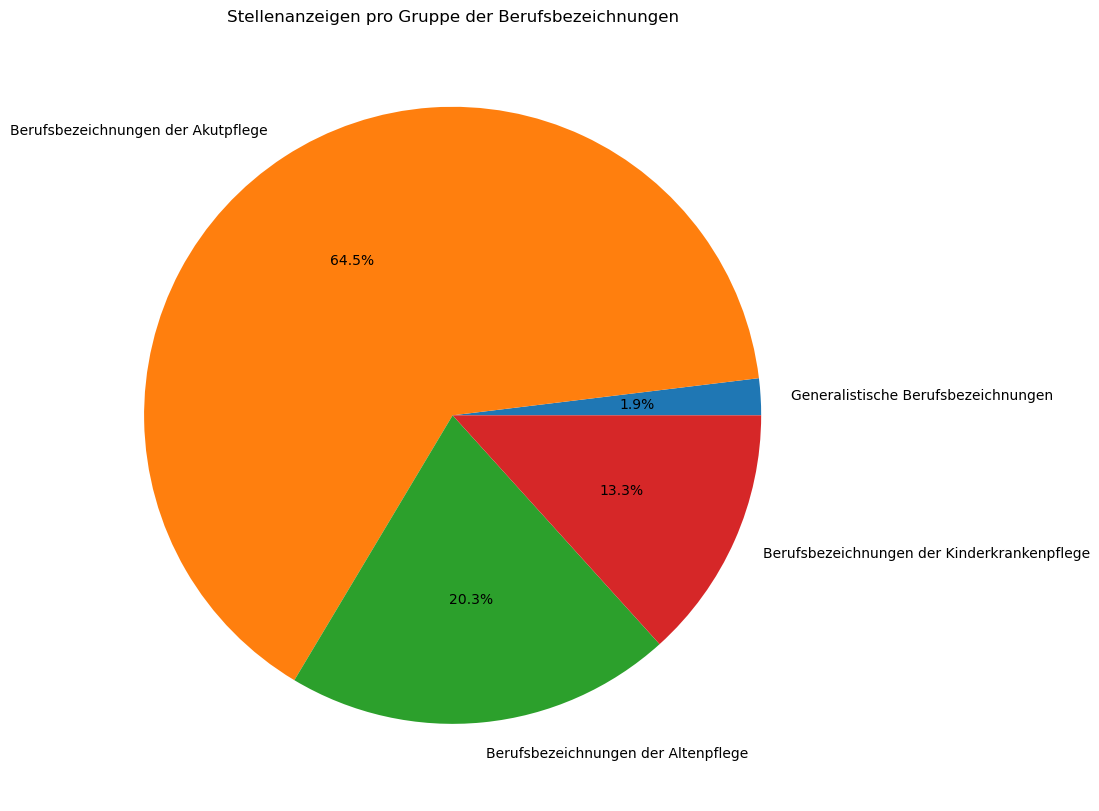

In [274]:
# Diagramm Plotten --> Torte --> Anzahl aller Stellenanzeigen nach Berufsgruppe (Gen(KH/AP))
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 8), constrained_layout=True, gridspec_kw={'height_ratios': [1]}) # viermal die eins am ende bei 4x4
gpiesizes = [counter_gen_gesamt, counter_kh_gesamt, counter_ap_gesamt, counter_ki_gesamt]
gpielabels = ['Generalistische Berufsbezeichnungen', 'Berufsbezeichnungen der Akutpflege', 'Berufsbezeichnungen der Altenpflege', 'Berufsbezeichnungen der Kinderkrankenpflege']
ax = axes
ax.pie(gpiesizes, labels=gpielabels, autopct='%1.1f%%')
ax.set_title('Stellenanzeigen pro Gruppe der Berufsbezeichnungen')
plt.show()

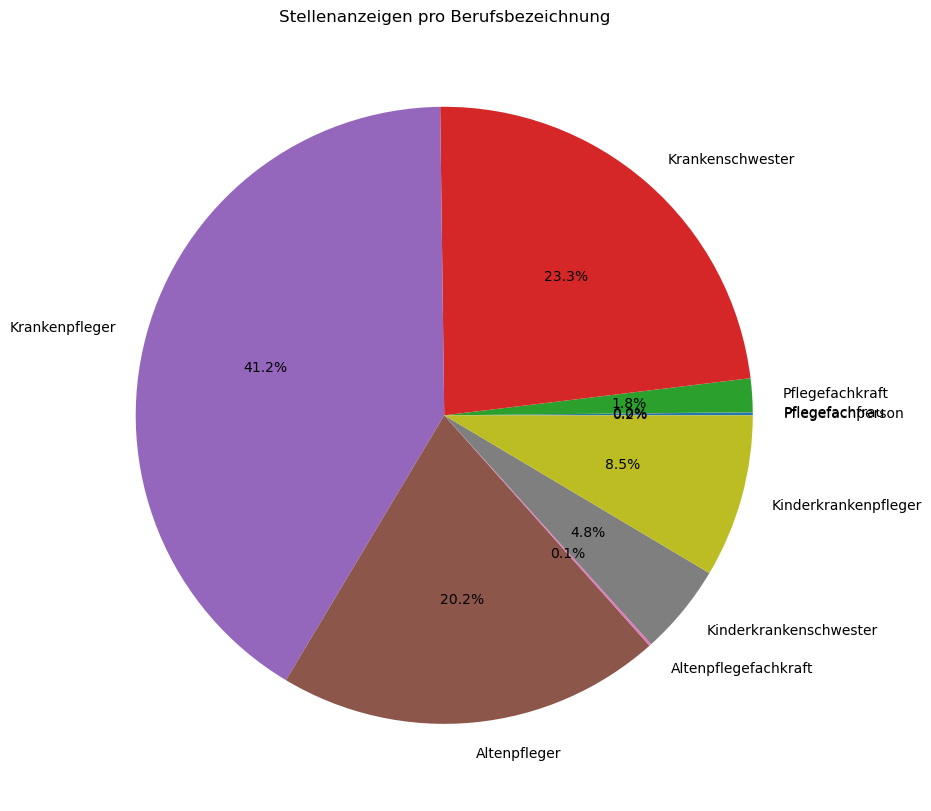

In [276]:
# Diagramm plotten --> Torte --> Anzahl aller Stellenanzeigen nach Berufsbezeichnung
bpiesizes = []
bpielabels = []
for csi in range(len(counter_gen)):
    if counter_gen[csi][1] > 0:
        bpiesizes.append(counter_gen[csi][1])
        bpielabels.append(counter_gen[csi][0])
for csio in range(len(counter_kh)):
    if counter_kh[csio][1] > 0:
        bpiesizes.append(counter_kh[csio][1])
        bpielabels.append(counter_kh[csio][0])
for csih in range(len(counter_ap)):
    if counter_ap[csih][1] > 0:
        bpiesizes.append(counter_ap[csih][1])
        bpielabels.append(counter_ap[csih][0])
for csii in range(len(counter_ki)):
    if counter_ki[csii][1] > 0:
        bpiesizes.append(counter_ki[csii][1])
        bpielabels.append(counter_ki[csii][0])
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 8), constrained_layout=True, gridspec_kw={'height_ratios': [1]})
ax = axes
ax.pie(bpiesizes, labels=bpielabels, autopct='%1.1f%%')
ax.set_title('Stellenanzeigen pro Berufsbezeichnung')
plt.show()

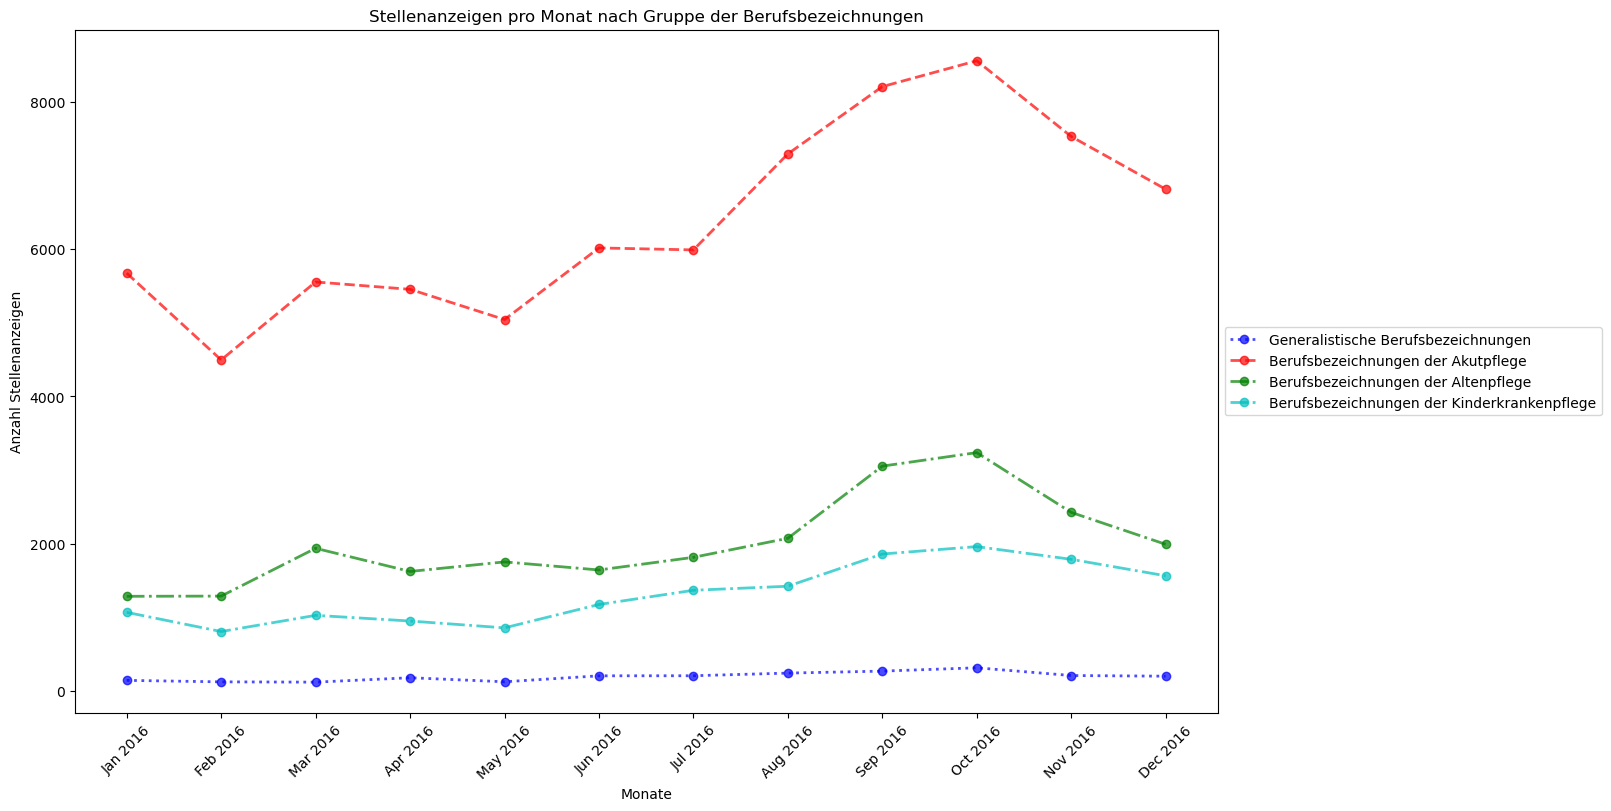

In [332]:
# Pro Monat nach Gruppe als Kurve
month_counts_gen = {month: 0 for month in months}
month_counts_kh = {month: 0 for month in months}
month_counts_ap = {month: 0 for month in months}
month_counts_ki = {month: 0 for month in months}
year_counts_gen = {year: 0 for year in years}
year_counts_kh = {year: 0 for year in years}
year_counts_ap = {year: 0 for year in years}
year_counts_ki = {year: 0 for year in years}
for item in range(len(stellen_full_gen)):
    ts = datetime.strptime(stellen_full_gen[item][0], "%Y-%m-%d")   
    month_counts_gen[(ts.year, ts.month)] = month_counts_gen.get((ts.year, ts.month), 0) + 1
    year_counts_gen[ts.year] = year_counts_gen.get(ts.year, 0) + 1
for itemt in range(len(stellen_full_kh)):
    ts = datetime.strptime(stellen_full_kh[itemt][0], "%Y-%m-%d")   
    month_counts_kh[(ts.year, ts.month)] = month_counts_kh.get((ts.year, ts.month), 0) + 1
    year_counts_kh[ts.year] += 1
for itemk in range(len(stellen_full_ap)):
    ts = datetime.strptime(stellen_full_ap[itemk][0], "%Y-%m-%d")   
    month_counts_ap[(ts.year, ts.month)] = month_counts_ap.get((ts.year, ts.month), 0) + 1
    year_counts_ap[ts.year] += 1    
for iteml in range(len(stellen_full_ki)):
    ts = datetime.strptime(stellen_full_ki[iteml][0], "%Y-%m-%d")   
    month_counts_ki[(ts.year, ts.month)] = month_counts_ki.get((ts.year, ts.month), 0) + 1
    year_counts_ki[ts.year] += 1   
ymonths_gen = list(month_counts_gen.values())
ymonths_kh = list(month_counts_kh.values())
ymonths_ap = list(month_counts_ap.values())
ymonths_ki = list(month_counts_ki.values())
yyears_gen = list(year_counts_gen.values())
yyears_kh = list(year_counts_kh.values())
yyears_ap = list(year_counts_ap.values())
yyears_ki = list(year_counts_ki.values())
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 8), constrained_layout=True, gridspec_kw={'height_ratios': [1]})
ax = axes #2, 0
ax.plot(xmonths, ymonths_gen, 'bo:', linewidth=2, label='Generalistische Berufsbezeichnungen', alpha=0.7)
ax.plot(xmonths, ymonths_kh, 'ro--', linewidth=2, label='Berufsbezeichnungen der Akutpflege', alpha=0.7)
ax.plot(xmonths, ymonths_ap, 'go-.', linewidth=2, label='Berufsbezeichnungen der Altenpflege', alpha=0.7)
ax.plot(xmonths, ymonths_ki, 'co-.', linewidth=2, label='Berufsbezeichnungen der Kinderkrankenpflege', alpha=0.7)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Stellenanzeigen pro Monat nach Gruppe der Berufsbezeichnungen')
ax.set_xlabel('Monate')
ax.set_ylabel('Anzahl Stellenanzeigen')
ax.set_xticks(xmonths)
ax.set_xticklabels(month_labels, rotation=45)
plt.show()

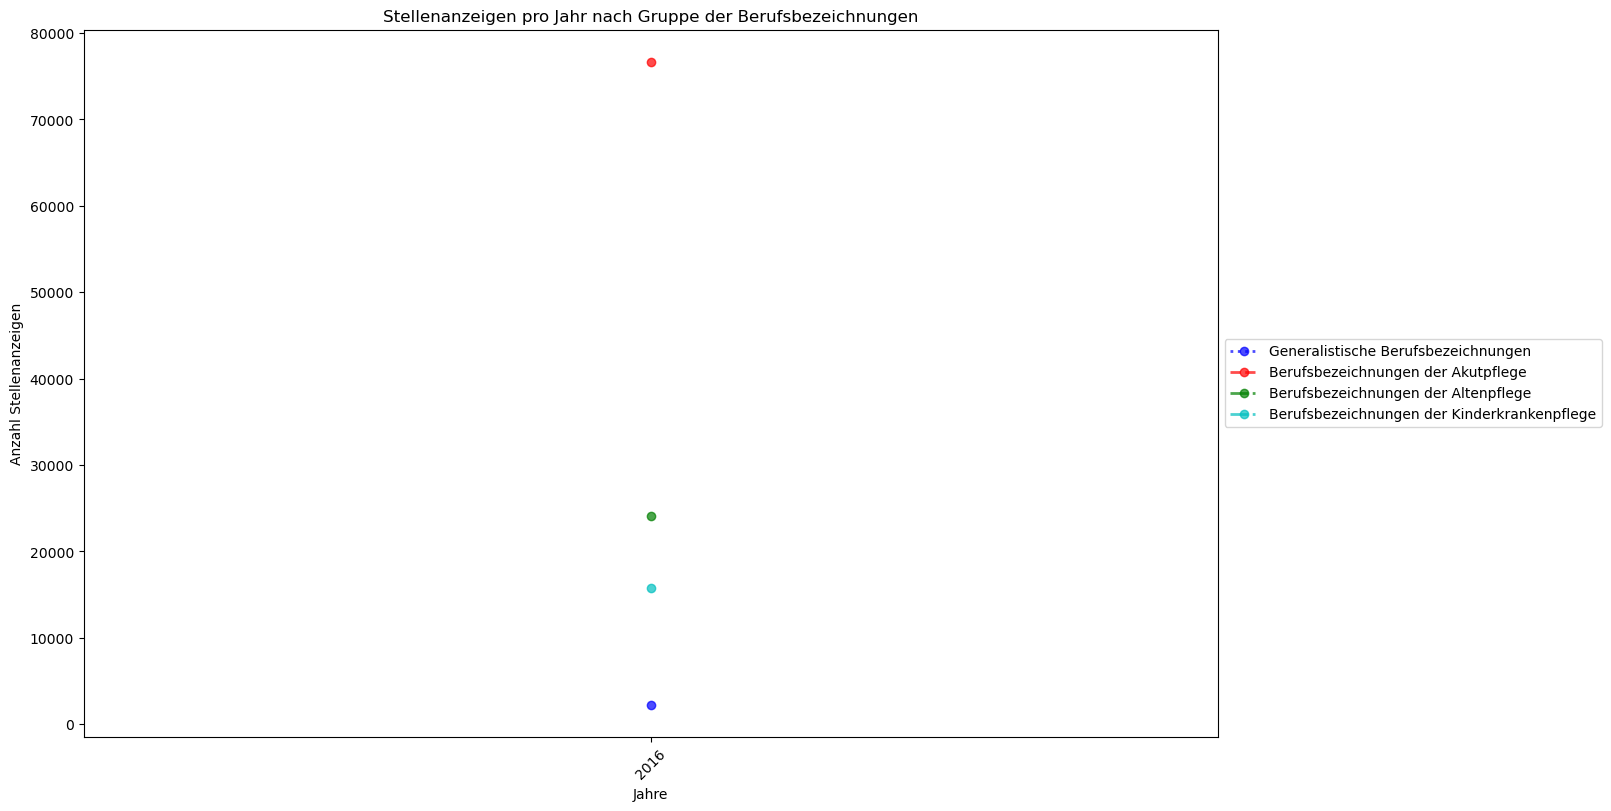

In [334]:
# Jetzt noch pro Jahr + Art
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 8), constrained_layout=True, gridspec_kw={'height_ratios': [1]}) # viermal die eins am ende bei 4x4
ax = axes # 2, 1
ax.plot(xyears, yyears_gen, 'bo:', linewidth=2, label='Generalistische Berufsbezeichnungen', alpha=0.7)
ax.plot(xyears, yyears_kh, 'ro--', linewidth=2, label='Berufsbezeichnungen der Akutpflege', alpha=0.7)
ax.plot(xyears, yyears_ap, 'go-.', linewidth=2, label='Berufsbezeichnungen der Altenpflege', alpha=0.7)
ax.plot(xyears, yyears_ki, 'co-.', linewidth=2, label='Berufsbezeichnungen der Kinderkrankenpflege', alpha=0.7)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Stellenanzeigen pro Jahr nach Gruppe der Berufsbezeichnungen')
ax.set_xlabel('Jahre')
ax.set_ylabel('Anzahl Stellenanzeigen')
ax.set_xticks(xyears)
ax.set_xticklabels(years, rotation=45)
plt.show()

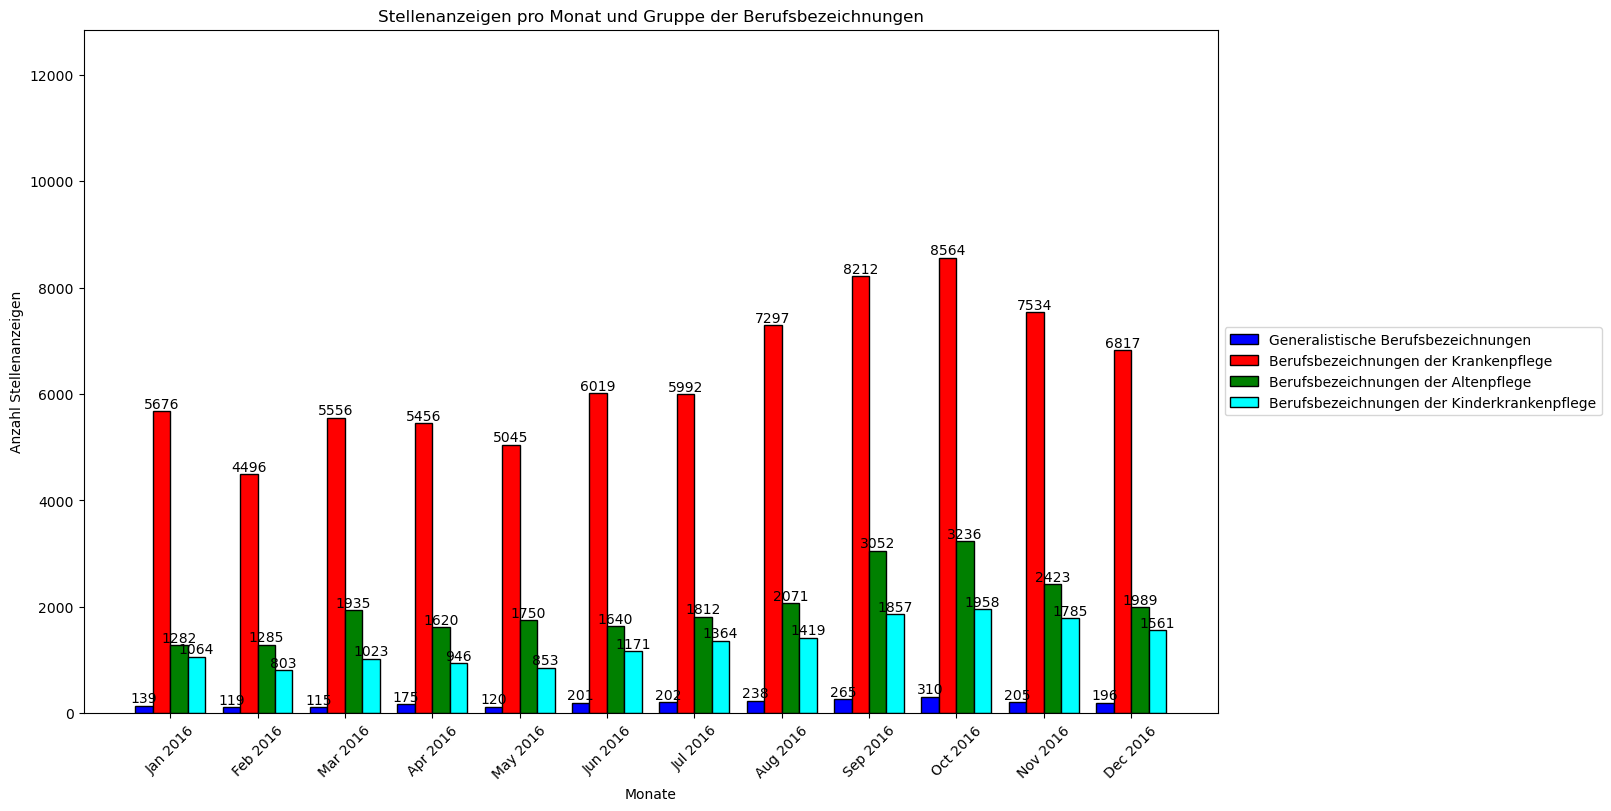

In [320]:
# Stellenanzeigen pro Monat/Jahr nach Gruppe als Bar Chart (statt Kurve)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 8), constrained_layout=True, gridspec_kw={'height_ratios': [1]}) # viermal die eins am ende bei 4x4
ax = axes # 3, 0
xmonths = np.arange(len(month_labels))
bar_width = 0.2
barthree = ax.bar(xmonths - 1.5 * bar_width, ymonths_gen, bar_width, color='blue', edgecolor='black', label='Generalistische Berufsbezeichnungen')
for rect in barthree:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.1, str(height), ha='center', va='bottom')
barfour = ax.bar(xmonths - 0.5 * bar_width, ymonths_kh, bar_width, color='red', edgecolor='black', label='Berufsbezeichnungen der Krankenpflege')
for rect in barfour:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.1, str(height), ha='center', va='bottom')
barfive = ax.bar(xmonths + 0.5 * bar_width, ymonths_ap, bar_width, color='green', edgecolor='black', label='Berufsbezeichnungen der Altenpflege')
for rect in barfive:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.1, str(height), ha='center', va='bottom')
barsix = ax.bar(xmonths + 1.5 * bar_width, ymonths_ki, bar_width, color='cyan', edgecolor='black', label='Berufsbezeichnungen der Kinderkrankenpflege')
for rect in barsix:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.1, str(height), ha='center', va='bottom')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.margins(y=0.5)
ax.set_xticks(xmonths)
ax.set_xticklabels(month_labels, rotation=45)
ax.set_xlabel('Monate')
ax.set_ylabel('Anzahl Stellenanzeigen')
ax.set_title('Stellenanzeigen pro Monat und Gruppe der Berufsbezeichnungen')
plt.show()

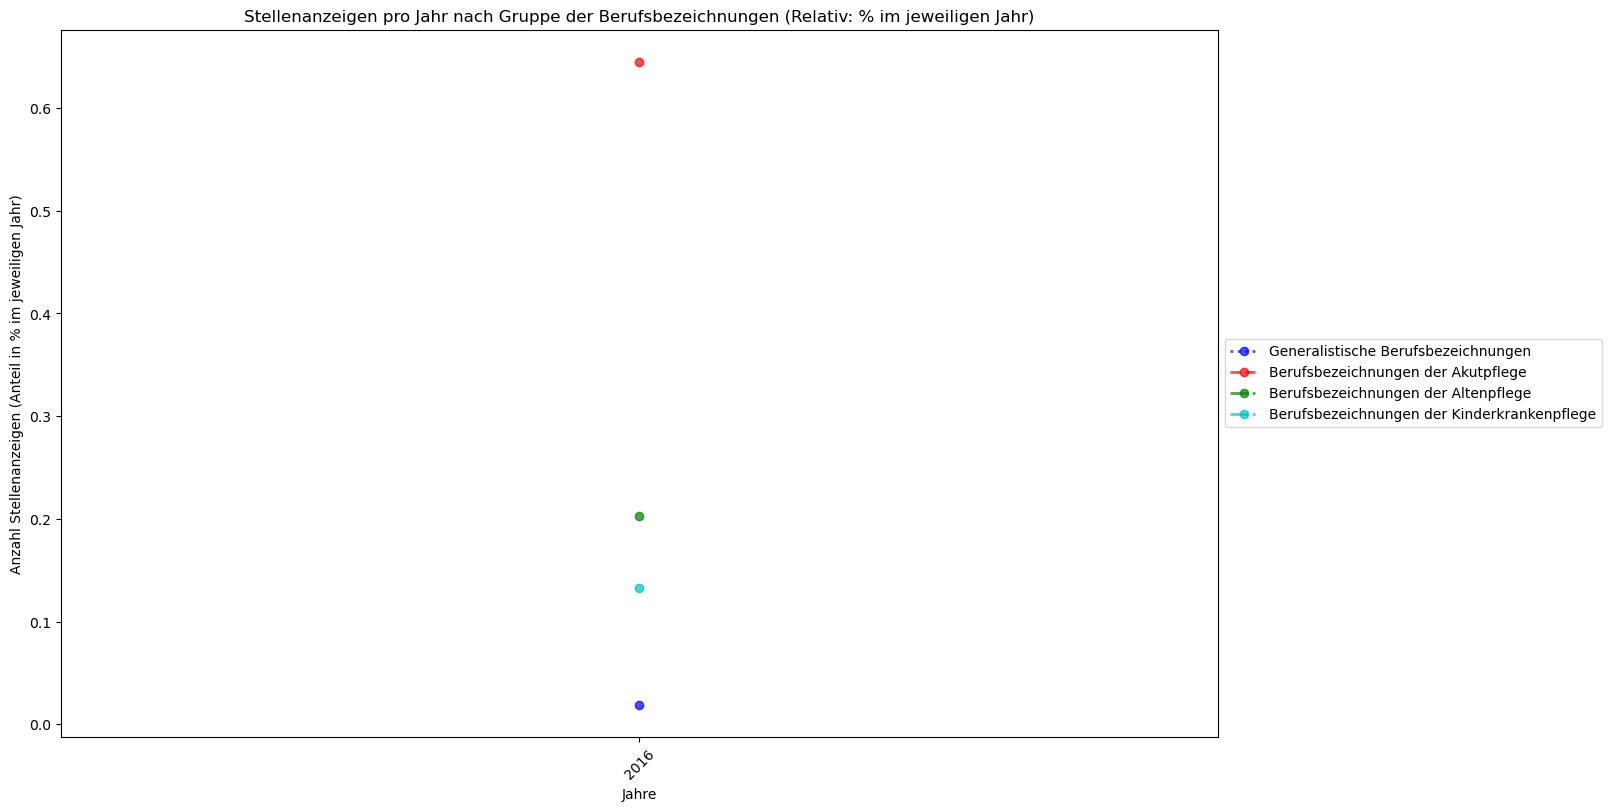

In [335]:
# ToDo: Bar/Kurve: Stellenanzeigen pro Gruppe pro Jahr/Monat - relativ
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 8), constrained_layout=True, gridspec_kw={'height_ratios': [1]}) # viermal die eins am ende bei 4x4
ax = axes
rel_yyears_gen = yyears_gen.copy()
rel_yyears_kh = yyears_kh.copy()
rel_yyears_ap = yyears_ap.copy()
rel_yyears_ki = yyears_ki.copy()
for c_yg in range(len(yyears_gen)):
    rel_yyears_gen[c_yg] = yyears_gen[c_yg]/(yyears_gen[c_yg]+yyears_ap[c_yg]+yyears_kh[c_yg]+yyears_ki[c_yg])
    rel_yyears_kh[c_yg] = yyears_kh[c_yg]/(yyears_gen[c_yg]+yyears_ap[c_yg]+yyears_kh[c_yg]+yyears_ki[c_yg])
    rel_yyears_ap[c_yg] = yyears_ap[c_yg]/(yyears_gen[c_yg]+yyears_ap[c_yg]+yyears_kh[c_yg]+yyears_ki[c_yg])
    rel_yyears_ki[c_yg] = yyears_ki[c_yg]/(yyears_gen[c_yg]+yyears_ap[c_yg]+yyears_kh[c_yg]+yyears_ki[c_yg])
ax.plot(xyears, rel_yyears_gen, 'bo:', linewidth=2, label='Generalistische Berufsbezeichnungen', alpha=0.7)
ax.plot(xyears, rel_yyears_kh, 'ro--', linewidth=2, label='Berufsbezeichnungen der Akutpflege', alpha=0.7)
ax.plot(xyears, rel_yyears_ap, 'go-.', linewidth=2, label='Berufsbezeichnungen der Altenpflege', alpha=0.7)
ax.plot(xyears, rel_yyears_ki, 'co-.', linewidth=2, label='Berufsbezeichnungen der Kinderkrankenpflege', alpha=0.7)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Stellenanzeigen pro Jahr nach Gruppe der Berufsbezeichnungen (Relativ: % im jeweiligen Jahr)')
ax.set_xlabel('Jahre')
ax.set_ylabel('Anzahl Stellenanzeigen (Anteil in % im jeweiligen Jahr)')
ax.set_xticks(xyears)
ax.set_xticklabels(years, rotation=45)
plt.show()

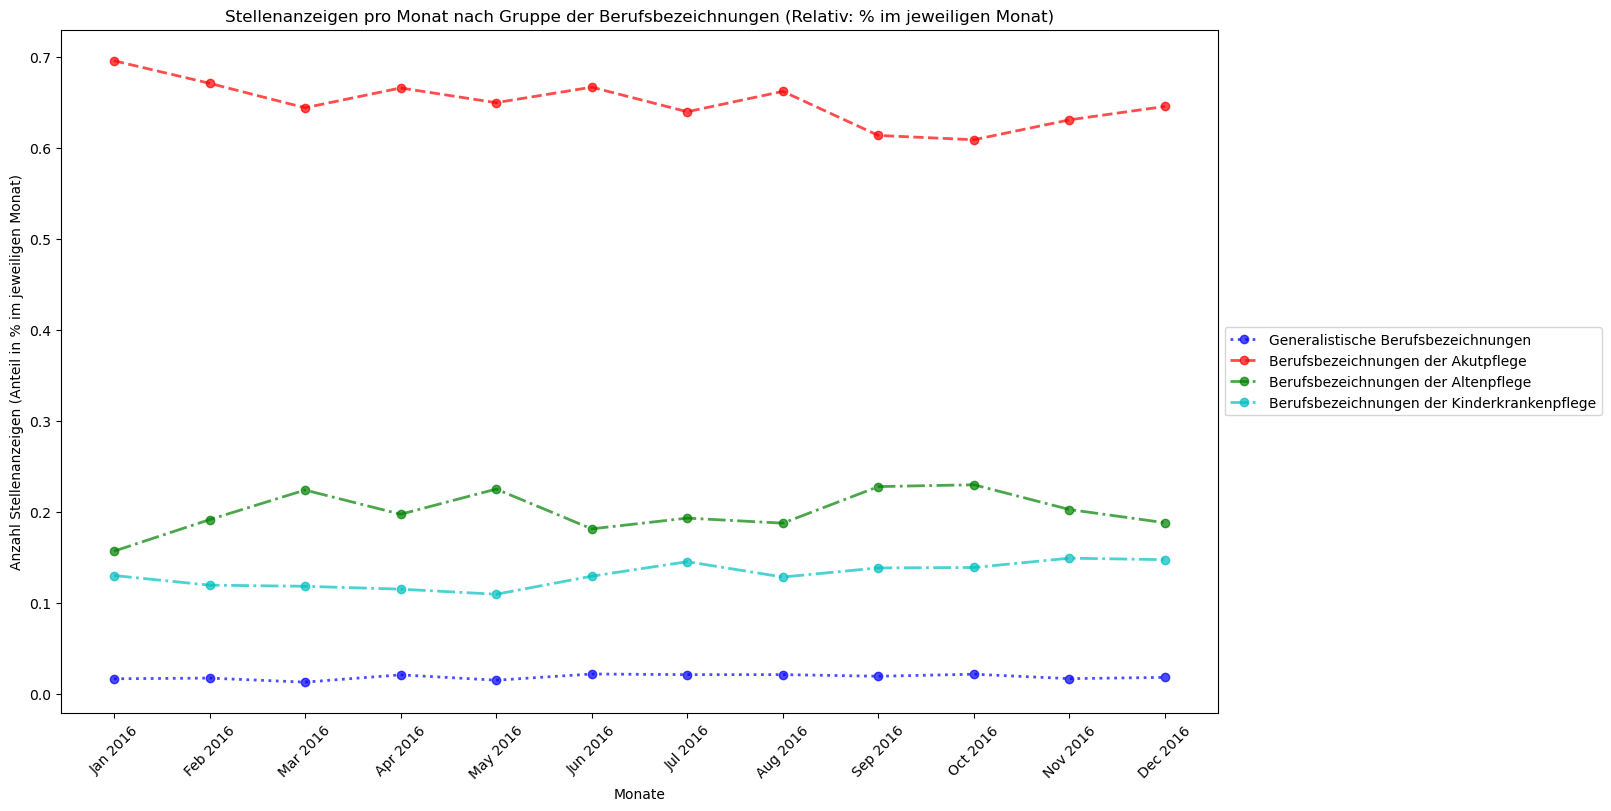

In [338]:
# Pro Monat
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 8), constrained_layout=True, gridspec_kw={'height_ratios': [1]}) # viermal die eins am ende bei 4x4
ax = axes
rel_ymonths_gen = ymonths_gen.copy()
rel_ymonths_kh = ymonths_kh.copy()
rel_ymonths_ap = ymonths_ap.copy()
rel_ymonths_ki = ymonths_ki.copy()
for c_yg in range(len(ymonths_gen)):
    rel_ymonths_gen[c_yg] = ymonths_gen[c_yg]/(ymonths_gen[c_yg]+ymonths_ap[c_yg]+ymonths_kh[c_yg]+ymonths_ki[c_yg])
    rel_ymonths_kh[c_yg] = ymonths_kh[c_yg]/(ymonths_gen[c_yg]+ymonths_ap[c_yg]+ymonths_kh[c_yg]+ymonths_ki[c_yg])
    rel_ymonths_ap[c_yg] = ymonths_ap[c_yg]/(ymonths_gen[c_yg]+ymonths_ap[c_yg]+ymonths_kh[c_yg]+ymonths_ki[c_yg])
    rel_ymonths_ki[c_yg] = ymonths_ki[c_yg]/(ymonths_gen[c_yg]+ymonths_ap[c_yg]+ymonths_kh[c_yg]+ymonths_ki[c_yg])
ax.plot(xmonths, rel_ymonths_gen, 'bo:', linewidth=2, label='Generalistische Berufsbezeichnungen', alpha=0.7)
ax.plot(xmonths, rel_ymonths_kh, 'ro--', linewidth=2, label='Berufsbezeichnungen der Akutpflege', alpha=0.7)
ax.plot(xmonths, rel_ymonths_ap, 'go-.', linewidth=2, label='Berufsbezeichnungen der Altenpflege', alpha=0.7)
ax.plot(xmonths, rel_ymonths_ki, 'co-.', linewidth=2, label='Berufsbezeichnungen der Kinderkrankenpflege', alpha=0.7)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Stellenanzeigen pro Monat nach Gruppe der Berufsbezeichnungen (Relativ: % im jeweiligen Monat)')
ax.set_xlabel('Monate')
ax.set_ylabel('Anzahl Stellenanzeigen (Anteil in % im jeweiligen Monat)')
ax.set_xticks(xmonths)
ax.set_xticklabels(month_labels, rotation=45)
plt.show()

In [221]:
# ToDo: Hochschulisch qualifizierte rausfiltern und darstellen

In [442]:
df['gen'] = pd.NA
df['kh'] = pd.NA
df['ki'] = pd.NA
df['ap'] = pd.NA
for i in range(len(pfp_gen)):
    result = df['full_text'].str.contains(pfp_gen[i], case=False, na=False)
    df.loc[result, 'gen'] = 1
for i in range(len(pfp_kh)):
    result = df['full_text'].str.contains(rf'\b{pfp_kh[i]}', case=False, na=False)
    df.loc[result, 'kh'] = 1
for i in range(len(pfp_ki)):
    result = df['full_text'].str.contains(pfp_ki[i], case=False, na=False)
    df.loc[result, 'ki'] = 1
for i in range(len(pfp_ap)):
    result = df['full_text'].str.contains(pfp_ap[i], case=False, na=False)
    df.loc[result, 'ap'] = 1

TypeError: unhashable type: 'Series'

In [406]:
row_count = len(df)
print(f"Anzahl gesamt: {row_count}")
count_gen = (df['gen'] == 1).sum()
print(f"Anzahl der generalistischen Berufsbezeichnungen: {count_gen}")
count_kh = (df['kh'] == 1).sum()
print(f"Anzahl der Berufsbezeichnungen der Akutpflege: {count_kh}")
count_ap = (df['ap'] == 1).sum()
print(f"Anzahl der Berufsbezeichnungen der Altenpflege: {count_ap}")
count_ki = (df['ki'] == 1).sum()
print(f"Anzahl der Berufsbezeichnungen der Kinderkrankenpflege: {count_ki}")
# Kombination von 'kh' und 'gen'
count_kh_gen = ((df['kh'] == 1) & (df['gen'] == 1)).sum()
print(f"Anzahl der Einträge mit kh = 1 und gen = 1: {count_kh_gen}")
# Kombination von 'kh' und 'ki'
count_kh_ki = ((df['kh'] == 1) & (df['ki'] == 1)).sum()
print(f"Anzahl der Einträge mit kh = 1 und ki = 1: {count_kh_ki}")
# Kombination von 'kh' und 'ap'
count_kh_ap = ((df['kh'] == 1) & (df['ap'] == 1)).sum()
print(f"Anzahl der Einträge mit kh = 1 und ap = 1: {count_kh_ap}")
# Kombination von 'gen' und 'ki'
count_gen_ki = ((df['gen'] == 1) & (df['ki'] == 1)).sum()
print(f"Anzahl der Einträge mit gen = 1 und ki = 1: {count_gen_ki}")
# Kombination von 'gen' und 'ap'
count_gen_ap = ((df['gen'] == 1) & (df['ap'] == 1)).sum()
print(f"Anzahl der Einträge mit gen = 1 und ap = 1: {count_gen_ap}")
# Kombination von 'ki' und 'ap'
count_ki_ap = ((df['ki'] == 1) & (df['ap'] == 1)).sum()
print(f"Anzahl der Einträge mit ki = 1 und ap = 1: {count_ki_ap}")
# Kombination von 'kh', 'gen' und 'ki'
count_kh_gen_ki = ((df['kh'] == 1) & (df['gen'] == 1) & (df['ki'] == 1)).sum()
print(f"Anzahl der Einträge mit kh = 1, gen = 1 und ki = 1: {count_kh_gen_ki}")
# Kombination von 'kh', 'gen' und 'ap'
count_kh_gen_ap = ((df['kh'] == 1) & (df['gen'] == 1) & (df['ap'] == 1)).sum()
print(f"Anzahl der Einträge mit kh = 1, gen = 1 und ap = 1: {count_kh_gen_ap}")
# Kombination von 'kh', 'ki' und 'ap'
count_kh_ki_ap = ((df['kh'] == 1) & (df['ki'] == 1) & (df['ap'] == 1)).sum()
print(f"Anzahl der Einträge mit kh = 1, ki = 1 und ap = 1: {count_kh_ki_ap}")
# Kombination von 'gen', 'ki' und 'ap'
count_gen_ki_ap = ((df['gen'] == 1) & (df['ki'] == 1) & (df['ap'] == 1)).sum()
print(f"Anzahl der Einträge mit gen = 1, ki = 1 und ap = 1: {count_gen_ki_ap}")

Anzahl gesamt: 118848
Anzahl der generalistischen Berufsbezeichnungen: 24249
Anzahl der Berufsbezeichnungen der Akutpflege: 84585
Anzahl der Berufsbezeichnungen der Altenpflege: 70021
Anzahl der Berufsbezeichnungen der Kinderkrankenpflege: 18249
Anzahl der Einträge mit kh = 1 und gen = 1: 17783
Anzahl der Einträge mit kh = 1 und ki = 1: 13373
Anzahl der Einträge mit kh = 1 und ap = 1: 44776
Anzahl der Einträge mit gen = 1 und ki = 1: 3591
Anzahl der Einträge mit gen = 1 und ap = 1: 18105
Anzahl der Einträge mit ki = 1 und ap = 1: 9344
Anzahl der Einträge mit kh = 1, gen = 1 und ki = 1: 3447
Anzahl der Einträge mit kh = 1, gen = 1 und ap = 1: 14325
Anzahl der Einträge mit kh = 1, ki = 1 und ap = 1: 8898
Anzahl der Einträge mit gen = 1, ki = 1 und ap = 1: 3056


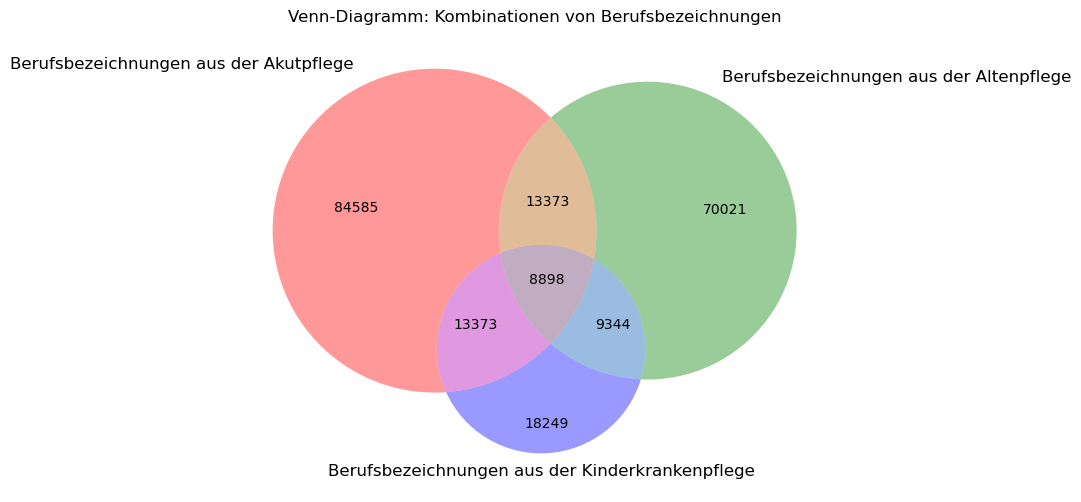

In [400]:
fig, ax = plt.subplots(figsize=(8, 6))  # Erstelle ein einzelnes Subplot
venn3(
    subsets=(
        count_kh,  # Nur kh
        count_ap,  # Nur gen
        count_kh_ki,  # kh & gen
        count_ki,  # Nur ki
        count_kh_ki,  # kh & ki
        count_ki_ap,  # gen & ki
        count_kh_ki_ap  # kh & gen & ki
    ),
    set_labels=('Berufsbezeichnungen aus der Akutpflege', 'Berufsbezeichnungen aus der Altenpflege', 'Berufsbezeichnungen aus der Kinderkrankenpflege'),
    ax=ax  # Weisen wir das Diagramm dem Subplot zu
)

ax.set_title("Venn-Diagramm: Kombinationen von Berufsbezeichnungen")

plt.show()

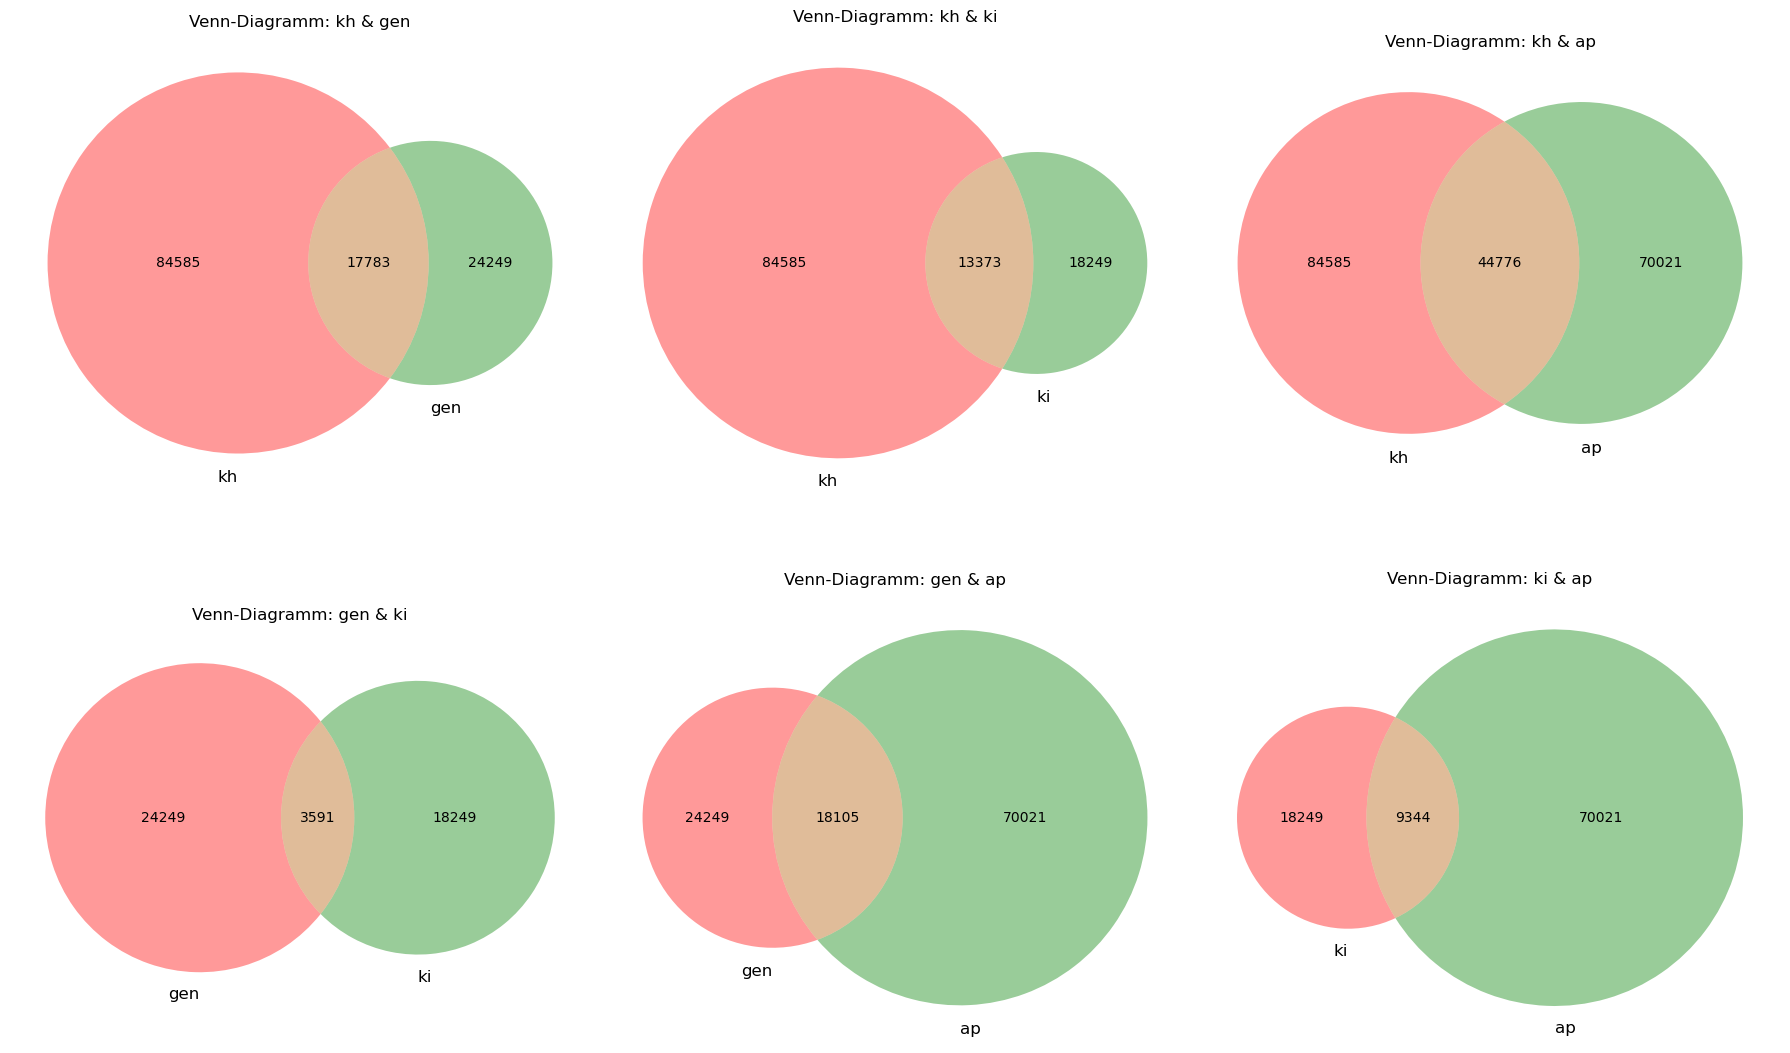

In [416]:
# Erstellen einer Figure mit 6 Subplots für die 2er-Kombinationen
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Definition der 2er-Kombinationen und ihrer Werte
combinations = [
    ("kh", "gen", count_kh, count_gen, count_kh_gen),
    ("kh", "ki", count_kh, count_ki, count_kh_ki),
    ("kh", "ap", count_kh, count_ap, count_kh_ap),
    ("gen", "ki", count_gen, count_ki, count_gen_ki),
    ("gen", "ap", count_gen, count_ap, count_gen_ap),
    ("ki", "ap", count_ki, count_ap, count_ki_ap)
]

# Zeichnen der Venn-Diagramme
for ax, (label1, label2, count1, count2, count_intersect) in zip(axes.flat, combinations):
    venn2(subsets=(count1, count2, count_intersect), set_labels=(label1, label2), ax=ax)
    ax.set_title(f"Venn-Diagramm: {label1} & {label2}")

plt.tight_layout()
plt.show()


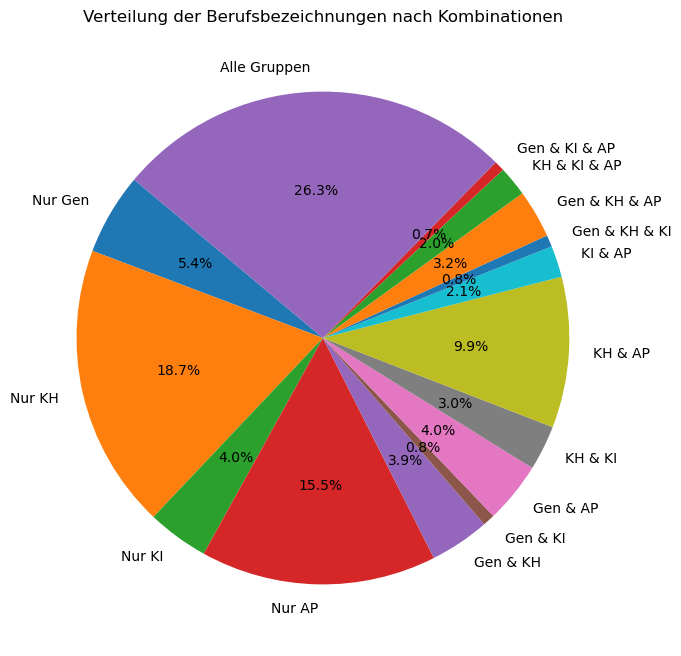

In [418]:
# Werte für die vier Hauptkategorien und ihre Kombinationen
sizes = [
    count_gen, count_kh, count_ki, count_ap, 
    count_kh_gen, count_gen_ki, count_gen_ap, count_kh_ki, count_kh_ap, count_ki_ap, 
    count_kh_gen_ki, count_kh_gen_ap, count_kh_ki_ap, count_gen_ki_ap, row_count
]

# Labels für das Diagramm
labels = [
    "Nur Gen", "Nur KH", "Nur KI", "Nur AP",
    "Gen & KH", "Gen & KI", "Gen & AP", "KH & KI", "KH & AP", "KI & AP",
    "Gen & KH & KI", "Gen & KH & AP", "KH & KI & AP", "Gen & KI & AP", "Alle Gruppen"
]

# Entferne Einträge mit Wert 0 für bessere Lesbarkeit
filtered_sizes = [size for size in sizes if size > 0]
filtered_labels = [label for size, label in zip(sizes, labels) if size > 0]

# Erstelle das Tortendiagramm
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(filtered_sizes, labels=filtered_labels, autopct='%1.1f%%', startangle=140)

# Titel setzen
ax.set_title("Verteilung der Berufsbezeichnungen nach Kombinationen")

# Zeige das Diagramm
plt.show()

In [450]:
# Zeitarbeit rausfiltern und neue Torte erstellen
# via_intermediary, contract_type
# print(df_full.iloc[0]
df_full['gen'] = pd.NA
df_full['kh'] = pd.NA
df_full['ki'] = pd.NA
df_full['ap'] = pd.NA
for i in range(len(pfp_gen)):
    result = df_full['full_text'].str.contains(pfp_gen[i], case=False, na=False)
    df_full.loc[result, 'gen'] = 1
for i in range(len(pfp_kh)):
    result = df_full['full_text'].str.contains(rf'\b{pfp_kh[i]}', case=False, na=False)
    df_full.loc[result, 'kh'] = 1
for i in range(len(pfp_ki)):
    result = df_full['full_text'].str.contains(pfp_ki[i], case=False, na=False)
    df_full.loc[result, 'ki'] = 1
for i in range(len(pfp_ap)):
    result = df_full['full_text'].str.contains(pfp_ap[i], case=False, na=False)
    df_full.loc[result, 'ap'] = 1
count_gen_oza = ((df_full['gen'] == 1) & (df_full['via_intermediary'] == False)).sum()
count_kh_oza = ((df_full['kh'] == 1) & (df_full['via_intermediary'] == False)).sum()
count_ki_oza = ((df_full['ki'] == 1) & (df_full['via_intermediary'] == False)).sum()
count_ap_oza = ((df_full['ap'] == 1) & (df_full['via_intermediary'] == False)).sum()
count_all_oza = (df_full['via_intermediary'] == False).sum()
print(count_gen)
print(count_gen_oza)
print(count_kh_oza)
print(count_ki_oza)
print(count_ap_oza)
print(count_all_oza)

24249
10373
35238
8021
27203
46628


In [ ]:
# Jetzt daraus praktisch die gleiche Diagramme wie oben mit den Werten mit ZA